# Which city to chose for your next citytrip?
## What problem to solve?
When you like to go on a city trip it’s always difficult to chose which city will be next. If you like a city how can you then tell what is the next city that you will most likely en enjoy to visit. To make this choice easier all big cities in the world will be grouped based on the venues that can be found within walking distance of there city center. This analysis will be interesting for people looking for there next nonstandard city trip, or companies advising tourist based on previous preferences. 

## what data to use?
First we wil define big cities as cities with a population of over 500.000. The website (https://worldpopulationreview.com/world-cities/) provides a comprehensive list of those cities. This data will be scraped form that website and provide a data frame that has a list of about 1100 cities and there total population. 
For example: (Tokyo, Japan, 37.393.129) 

Walking distance will be defined as 5km from the city center. The city center information will come from the geopy package and will consist of a latitude and longitude. To get this data we wil use the cities from the word-cities dataset as input for the geopy package.
For example: (Toronto, 43.65, -79.34)

We will ask the Foursquare API to provide a list of the top 100 venues within the walking distance of the city center. This data will be analyzed, clustered and visualized on a word map. This data will consist of a coordinate that comes from the data from the geopy package. 
For example: (43.65, -79.34, park, Chinese restaurant, bowling, etc.)

## Next steps
To achieve this analysis we will have to do some steps:
    - Part 1: import all the necessary packages
    - Part 2: collect all the data & clean the data
    - Part 3: The Analysis
    - Part 4: make the visualiziation


### Part 1: import all the necessary packages
these are al the packages that we need to run this notebook

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import geopy and folium
!conda install -c conda-forge geopy --yes # uncomment this line if the package is not yet installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if the package is not yet installed
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import BeautifulSoup for data scraping
!conda install -c anaconda beautifulsoup4 --yes # uncomment this line if the package is not yet installed
from bs4 import BeautifulSoup

import time

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/nbuser/anaconda3_501

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    conda-package-handling-1.6.0|   py36h8c4c3a4_2         947 KB  conda-forge
    conda-4.8.2                |           py36_0         3.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following

sphinxcontrib-jsmath | 7 KB      | ##################################### | 100% 
importlib-metadata-1 | 43 KB     | ##################################### | 100% 
json5-0.9.0          | 24 KB     | ##################################### | 100% 
altair-4.1.0         | 614 KB    | ##################################### | 100% 
branca-0.4.1         | 26 KB     | ##################################### | 100% 
certifi-2020.4.5.1   | 151 KB    | ##################################### | 100% 
sphinxcontrib-htmlhe | 27 KB     | ##################################### | 100% 
wurlitzer-2.0.0      | 12 KB     | ##################################### | 100% 
importlib_metadata-1 | 3 KB      | ##################################### | 100% 
soupsieve-2.0.1      | 56 KB     | ##################################### | 100% 
backports.os-0.1.1   | 15 KB     | ##################################### | 100% 
scikit-learn-0.20.1  | 5.7 MB    | ##################################### | 100% 
sphinxcontrib-serial | 24 KB

### Part 2: collect all the data & clean te data
Now its time to collect al the data, clean it and make the final dataframe.

#### Part 2.1: scrape the data from a website
lets scrape the data from https://worldpopulationreview.com/world-cities/ to collect all the cities in the world with more than 500.000 inhabitans

In [2]:
# Here, we're just importing Beautiful Soup
page_link = 'https://worldpopulationreview.com/world-cities/'
# this is the url.
page_response = requests.get(page_link, timeout=5)
# here, we fetch the content from the url, using the requests library
soup = BeautifulSoup(page_response.content, "html.parser")
#we use the html parser to parse the url content and store it in a variable.
table = soup.find_all('table')
world_cities = pd.read_html(str(table), header=0)[0]

In [3]:
print(world_cities.shape)
world_cities.head()

(1133, 6)


,Rank,Name,Country,2020 Population,2019 Population,Change
0,1,Tokyo,Japan,37393129,37435191,-0.11%
1,2,Delhi,India,30290936,29399141,3.03%
2,3,Shanghai,China,27058479,26317104,2.82%
3,4,Sao Paulo,Brazil,22043028,21846507,0.90%
4,5,Mexico City,Mexico,21782378,21671908,0.51%


we dont need the ranking, population in 2019 and change in population.

In [4]:
#drop the unecessary columns
world_cities.drop(['Rank', '2019 Population', 'Change'], axis=1, inplace=True)

#give the columns proper names
world_cities.rename(columns={"Name": "City", "2020 Population": "Population"}, inplace=True)

world_cities.head()

,City,Country,Population
0,Tokyo,Japan,37393129
1,Delhi,India,30290936
2,Shanghai,China,27058479
3,Sao Paulo,Brazil,22043028
4,Mexico City,Mexico,21782378


In [5]:
world_cities_ll = pd.DataFrame(world_cities, columns=['City', 'Country', 'Population', 'latitude', 'longitude'])
world_cities_ll.head()

,City,Country,Population,latitude,longitude
0,Tokyo,Japan,37393129,NaN,NaN
1,Delhi,India,30290936,NaN,NaN
2,Shanghai,China,27058479,NaN,NaN
3,Sao Paulo,Brazil,22043028,NaN,NaN
4,Mexico City,Mexico,21782378,NaN,NaN


#### Part 2.2: get the coordinates
It is time to get the latitude and longitude of every city in the list using geopy. 

In [6]:
%%script false --no-raise-error # uncomment this line to skip cell, because the computation takes a long time and is only needed the first time you run the notebook.

# create a for loop to fill the latlon dataframe
i = 0

for city, country in zip(world_cities_ll['City'], world_cities_ll['Country']):
    adress = '{}, {}'.format(city, country)
    geolocator = Nominatim(user_agent="city_explorer")
    a = geolocator.geocode(adress)
    # this prevents the for loop from stopping if there is no result 
    try:
        world_cities_ll.at[i, 'latitude'] = a.latitude
    except:
        pass
    try:
        world_cities_ll.at[i, 'longitude'] = a.longitude
    except:
        pass
    time.sleep(2) # uncomment this line if you get 'Too Many Requests 429, or a Runtime error'
    i = i+1

In [7]:
# Because the data collection takes so long we store the data in a CSV. 
# Next time we open the notebook we don't have redo the whole process.

# Store to CSV
#world_cities_ll.to_csv(r'world_cities_ll.csv', index = False)  # uncomment this line to store the data in a CSV file

# Collect the data
world_cities_ll = pd.read_csv('world_cities_ll.csv')  # uncomment this line to get the data from the CSV file

In [8]:
#Lets check if there are NaN values in the dataframe
print(world_cities_ll.isnull().sum(axis = 0))

#and check how many rows the dataframe has
print(world_cities_ll.shape)

City          0
Country       0
Population    0
latitude      8
longitude     8
dtype: int64
(1133, 5)


In [9]:
# drop the rows were there was no coordinate found
world_cities_ll.dropna(axis=0, inplace=True)
print(world_cities_ll.shape)
world_cities_ll.isnull().sum(axis = 0)

(1125, 5)


City          0
Country       0
Population    0
latitude      0
longitude     0
dtype: int64

#### Part 2.3: add the foursquare venue data
Now that we have our dataframe with coordinates, we can use that to make requests for venue information via the Foursquare API. lets first initialise our credentials.

In [10]:
CLIENT_ID = '______' # your Foursquare ID
CLIENT_SECRET = '______' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Now we create a function that can find the top 100 venues for each city.

Then we use te function to store the data in a new dataframe.

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    n = 0    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(names)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            print(n)
            n = n+1
            time.sleep(2)
        except KeyError:
            requests.get(url).json()
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [12]:
%%script false --no-raise-error # uncomment this line to skip cell, because the computation takes a long time and is only needed the first time you run the notebook.

world_cities_venues = getNearbyVenues(names=world_cities_ll['City'],
                                   latitudes=world_cities_ll['latitude'],
                                   longitudes=world_cities_ll['longitude']
                                  )

In [13]:
# Because the data collection takes so long we store the data in a CSV. 
# Next time we open the notebook we don't have redo the whole process.

# Store to CSV
# world_cities_venues.to_csv(r'world_cities_venues.csv', index = False)  # uncomment this line to store the data in a CSV file

# Collect the data
 world_cities_venues = pd.read_csv('world_cities_venues.csv')  # uncomment this line to get the data from the CSV file

In [14]:
print(world_cities_venues.shape)
world_cities_venues.head()

(55642, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tokyo,35.682839,139.759455,Palace Hotel Tokyo (パレスホテル東京),35.684644,139.761302,Hotel
1,Tokyo,35.682839,139.759455,Kokyo Gaien (皇居外苑),35.679928,139.758562,Garden
2,Tokyo,35.682839,139.759455,Wolfgang's Steakhouse,35.679185,139.762134,Steakhouse
3,Tokyo,35.682839,139.759455,Aman Tokyo (アマン東京),35.685236,139.765401,Hotel
4,Tokyo,35.682839,139.759455,Mitsubishi Ichigokan Museum (三菱一号館美術館),35.678420,139.763260,Art Museum


Lets disregard every city where we didn't get a hunderd venues from the Foursquare API. These cities are probably no normal tourist destinations and will also badly influence the analysis. Firts we check which cities have 100 venues in our data.

In [15]:
# Group the dataframe by city to check how many venues each city has
world_cities_grouped = world_cities_venues.groupby('City').count()
world_cities_grouped.rename(columns={'Venue':'Venue_Count'}, inplace=True)
world_cities_grouped.reset_index(inplace=True)

# Drop al columns that are not needed
world_cities_grouped.drop(['City Latitude', 
                           'City Longitude', 
                           'Venue Latitude', 
                           'Venue Longitude', 
                           'Venue Category'], 
                           axis=1, inplace=True)
world_cities_grouped.head()

,City,Venue_Count
0,Aba,4
1,Abakaliki,6
2,Abeokuta,6
3,Abidjan,58
4,Abomey Calavi,6


In [16]:
# count the number of cities with 100 venues in the dataframe
world_cities_grouped.groupby('Venue_Count').count().sort_index(ascending=False).head()

,City
Venue_Count,
200,1
100,417
99,1
98,1
97,4


Now we know which cities have 100 venues in the dataframe an that there are a total of 417 of them. Next step is to delete al the cities that do not have 100 venues in our data. 

In [17]:
# Merge world_cities_venues and world_cities_grouped
world_cities_venues = world_cities_venues.merge(world_cities_grouped, left_on='City', right_on='City')

# Only keep the rows were Venue_Count is 100
world_cities_venues = world_cities_venues[world_cities_venues.Venue_Count == 100]

# Delete the column Venue_Count
world_cities_venues.drop(columns='Venue_Count', inplace=True)

# world_cities_venuesr should have 417 x 100 = 41700 rows
print(world_cities_venues.shape)
world_cities_venues.head()

(41700, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tokyo,35.682839,139.759455,Palace Hotel Tokyo (パレスホテル東京),35.684644,139.761302,Hotel
1,Tokyo,35.682839,139.759455,Kokyo Gaien (皇居外苑),35.679928,139.758562,Garden
2,Tokyo,35.682839,139.759455,Wolfgang's Steakhouse,35.679185,139.762134,Steakhouse
3,Tokyo,35.682839,139.759455,Aman Tokyo (アマン東京),35.685236,139.765401,Hotel
4,Tokyo,35.682839,139.759455,Mitsubishi Ichigokan Museum (三菱一号館美術館),35.678420,139.763260,Art Museum


### Part 3: The Analysis
The final dataframe is made so we kan proceed to cluster al the city's

#### Part 3.1: Prepare for Analysis
Now that we have all the cleaned information in our dataframe we need to prepare it for the analysis. Therefore we will create dummy variables and group the means by neighborhood to make the dataframe ready for K-means analysis.

In [18]:
# one hot encoding
world_cities_onehot = pd.get_dummies(world_cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add City column back to dataframe
world_cities_onehot['City'] = world_cities_venues['City'] 

# move City column to the first column
fixed_columns = [world_cities_onehot.columns[-1]] + list(world_cities_onehot.columns[:-1])
world_cities_onehot = world_cities_onehot[fixed_columns]

print(world_cities_onehot.shape)
world_cities_onehot.head()

(41700, 668)


,Zoo Exhibit,ATM,Acai House,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Apple Wine Pub,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baiano Restaurant,Bakery,Balinese Restaurant,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Bengali Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Borek Place,Bosnian Restaurant,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Bunsik Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Chaat Place,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Circus,City,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Lab,College Library,College Quad,College Rec Center,College Science Building,College Soccer Field,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dairy Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Estaminet,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gilaki Restaurant,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,

In [19]:
world_cities_grouped_dummy = world_cities_onehot.groupby('City').mean().reset_index()
world_cities_grouped_dummy.head()

,City,Zoo Exhibit,ATM,Acai House,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Apple Wine Pub,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baiano Restaurant,Bakery,Balinese Restaurant,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Bengali Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Borek Place,Bosnian Restaurant,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Bunsik Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Chaat Place,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Lab,College Library,College Quad,College Rec Center,College Science Building,College Soccer Field,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dairy Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Estaminet,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gilaki Restaurant,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,

Lets also make a top 10 venue list for every city

In [20]:
#function to sort on most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
world_cities_venues_sorted = pd.DataFrame(columns=columns)
world_cities_venues_sorted['City'] = world_cities_grouped_dummy['City']

for ind in np.arange(world_cities_grouped_dummy.shape[0]):
    world_cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(world_cities_grouped_dummy.iloc[ind, :], num_top_venues)

print(world_cities_venues_sorted.shape)
world_cities_venues_sorted.head()

(417, 11)


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Dhabi,Café,Hotel,Middle Eastern Restaurant,Coffee Shop,Chinese Restaurant,Restaurant,Park,Dessert Shop,Asian Restaurant,Beach
1,Abuja,Hotel,Restaurant,Lounge,Fast Food Restaurant,Arcade,Nightclub,Café,Pizza Place,BBQ Joint,Movie Theater
2,Acapulco De Juarez,Seafood Restaurant,Mexican Restaurant,Taco Place,Restaurant,Beach,Coffee Shop,Food Truck,Italian Restaurant,Burger Joint,Ice Cream Shop
3,Accra,Hotel,African Restaurant,Fast Food Restaurant,Bar,Cocktail Bar,Shopping Mall,Bakery,Pizza Place,Nightclub,Restaurant
4,Ad Dammam,Coffee Shop,Bakery,Juice Bar,Ice Cream Shop,Donut Shop,Café,Supermarket,Dessert Shop,Restaurant,Middle Eastern Restaurant


#### Part 3.2: Perform the Analysis
First we are going to check what the best number of clusters is voor the K-means analysis using the elbow methode

In [22]:
# first we need drop the City column to perform the analyses.
world_cities_grouped_dummy_clustering = world_cities_grouped_dummy.drop('City', 1)

#Then run the K value for 20 times. It will always get closer to zero if K is bigger.
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(world_cities_grouped_dummy_clustering)
    Sum_of_squared_distances.append(km.inertia_)

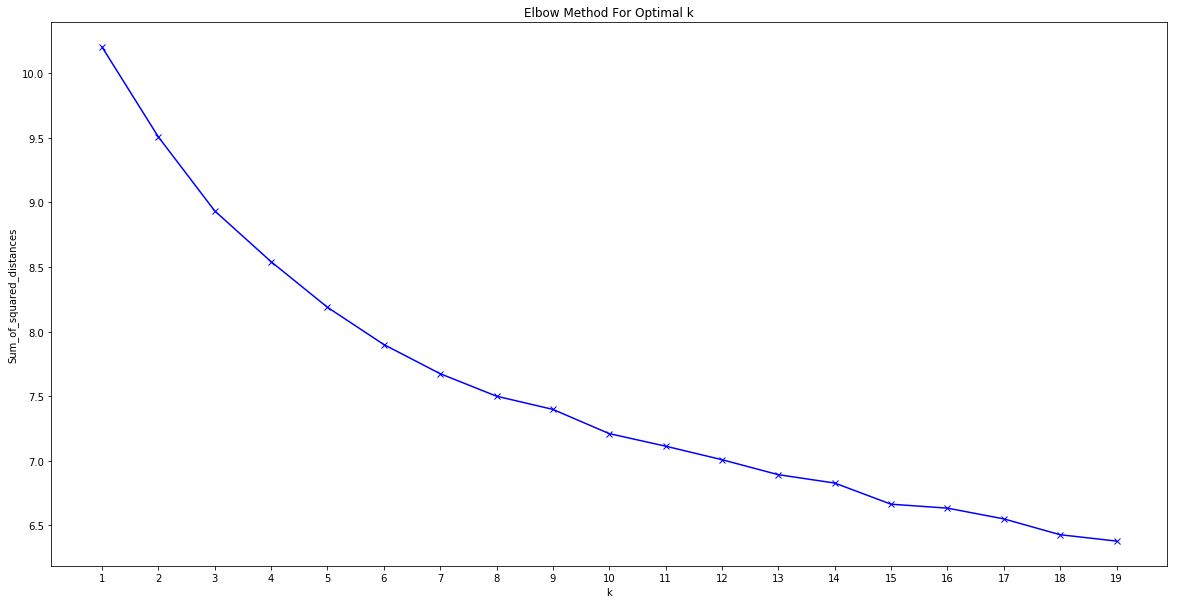

In [23]:
# To find the best K value we look for the knee in the plot
plt.figure(figsize=(20,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xticks(range(1,20))
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

although the plot is not very clear. The clearest elbow is at 14 so we will chose that number for K. Now we are going to create the clusters.

In [24]:
# set number of clusters
kclusters = 14

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(world_cities_grouped_dummy_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 7,  7, 11,  9,  4, 13,  4,  5,  2,  2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
# add clustering labels
world_cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

world_cities_merged = world_cities_ll

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
world_cities_merged = world_cities_merged.join(world_cities_venues_sorted.set_index('City'), on='City')

print(world_cities_merged.shape)
world_cities_merged.head() # check the last columns!

(1125, 16)


,City,Country,Population,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tokyo,Japan,37393129,35.682839,139.759455,7.0,Hotel,Coffee Shop,Japanese Restaurant,Soba Restaurant,Café,Ramen Restaurant,Japanese Curry Restaurant,Hobby Shop,Sushi Restaurant,Yoshoku Restaurant
1,Delhi,India,30290936,28.651718,77.221939,10.0,Indian Restaurant,Hotel,Café,Lounge,Snack Place,Bakery,History Museum,Breakfast Spot,Bar,Fast Food Restaurant
2,Shanghai,China,27058479,31.232276,121.469207,9.0,Hotel,Coffee Shop,French Restaurant,Spa,Shopping Mall,Dumpling Restaurant,Italian Restaurant,Lounge,Gym / Fitness Center,Chinese Restaurant
3,Sao Paulo,Brazil,22043028,-23.550651,-46.633382,6.0,Italian Restaurant,Ice Cream Shop,Pizza Place,Theater,Bakery,Brazilian Restaurant,Cosmetics Shop,Art Museum,Grocery Store,Movie Theater
4,Mexico City,Mexico,21782378,19.432630,-99.133178,11.0,Mexican Restaurant,Bakery,Art Museum,Ice Cream Shop,Plaza,History Museum,Taco Place,Deli / Bodega,Hotel,Museum


In [26]:
#since there are more cities is world_cities_ll then in world_cities_grouped_dummy_clustering we have rows with cluster value NaN. They have to be droped
world_cities_merged = world_cities_merged.dropna()
world_cities_merged = world_cities_merged.reset_index(drop=True)

# This should show 417 rows
print(world_cities_merged.shape)

#then the type in column Cluster Labels should be changed from float to int
world_cities_merged = world_cities_merged.astype({'Cluster Labels': 'int64'})
print(world_cities_merged.dtypes)

(417, 16)
City                       object
Country                    object
Population                  int64
latitude                  float64
longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object


In [27]:
world_cities_merged.groupby('Cluster Labels').count().sort_index(ascending=False)

,City,Country,Population,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
13,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
12,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
11,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
10,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
9,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
8,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
7,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
6,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41
5,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38


### Part 4: make the visualiziation
Lets make a interactive map of our clustered city information.

In [28]:
# create map
map_clusters = folium.Map(location=[0, 0], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(world_cities_merged['latitude'], world_cities_merged['longitude'], world_cities_merged['City'], world_cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters